# Introductory applied machine learning (INFR10069)

# Assignment 4: Feature Engineering

## Marking Breakdown

**70-100%** results/answer correct plus extra achievement at understanding or analysis of results. Clear explanations, evidence of creative or deeper thought will contribute to a higher grade.

**60-69%** results/answer correct or nearly correct and well explained.

**50-59%** results/answer in right direction but significant errors.

**40-49%** some evidence that the student has gained some understanding, but not answered the questions
properly.

**0-39%** serious error or slack work.


## Mechanics

You should produce a Jupyter notebook in answer to this assignment.
**You need to submit this notebook electronically as described below.**

Place your notebook in a directory called `iamlans` and submit this directory using the submit command on a DICE machine. The format is:

`submit iaml 4 iamlans`

You can check the status of your submissions with the `show_submissions` command.

**Late submissions:** The policy stated in the School of Informatics MSc Degree Guide is that normally you will not be allowed to submit coursework late. See http://www.inf.ed.ac.uk/teaching/years/msc/courseguide10.html#exam for exceptions to this, e.g. in case of serious medical illness or serious personal problems.

**Collaboration:** You may discuss the assignment with your colleagues, provided that the writing that you submit is entirely your own. That is, you should NOT borrow actual text or code from other students. We ask that you provide a list of the people who you've had discussions with (if any).

## Important Instructions

1. In the following questions you are asked to run experiments using Python (version 2.7) and the following packages:
    * Numpy
    * Pandas
    * Scikit-learn 0.17
    * Matplotlib
    * Seaborn

2. Before you start make sure you have set up a vitual environment (or conda environment if you are working on your own machine) and the required packages installed. Instructions on how to set-up the working enviornment and install the required packages can be found in `01_Lab_1_Introduction`.

3. Wherever you are required to produce code you should use code cells, otherwise you should use markdown cells to report results and explain answers. **You are welcome to split your answer into multiple cells with intermediate printing.**

4. The .csv files that you will be using are located at `./datasets` (the `datasets` directory is adjacent to this file).

5. **IMPORTANT:** Keep your answers brief and concise. Most questions can be answered with 2-3 lines of explanation (excluding coding questions), unless stated otherwise.

## Imports

In this assignment you are asked to import all the packages and modules you will need. Include all required imports and execute the cell below.

In [1]:
from __future__ import print_function, division
%matplotlib inline

In [2]:
import os
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import confusion_matrix
from sklearn import linear_model, decomposition
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import train_test_split, KFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB

## Description of the datasets


This assignment is based on two datasets:
1. the 20 Newsgroups Dataset (you should recognise it from Assignment 1)
2. the MNIST digits dataset

### 20 Newsgroups

For convenience, we repeat the description here. This dataset is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related to each other (e.g. comp.sys.ibm.pc.hardware, comp.sys.mac.hardware), while others are highly unrelated (e.g misc.forsale, soc.religion.christian). 

To save you time and to make the problem manageable with limited computational resources, we preprocessed the original dataset. We will use documents from only 5 out of the 20 newsgroups, which results in a 5-class problem. More specifically the 5 classes correspond to the following newsgroups: 
1. `alt.atheism`
2. `comp.sys.ibm.pc.hardware`
3. `comp.sys.mac.hardware`
4. `rec.sport.baseball`
5. `rec.sport.hockey `

However, note here that classes 2-3 and 4-5 are rather closely related.

**In contrast to Assignment 1**, we have opted to use tf-idf weights ([term frequency - inverse document frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf))
for each word instead of the frequency counts. These weights represent the importance of a word to a
document with respect to a collection of documents. The importance increases proportionally to the number
of times a word appears in the document and decreases proportionally to the number of times the word
appears in the whole corpus. 

Additionally we preprocess the data to include the most frequent 1000 words that are in greater than 2 documents, less than half of all documents, and that are not [stop words](https://en.wikipedia.org/wiki/Stop_words).

We will perform all this preprocessing for you.


### MNIST
This MNIST Dataset is a collection handwritten digits. The samples are partitioned (nearly) evenly across the 10 different digit classes {0, 1, . . . , 9}. We use a preprocessed version for which the data are $8 \times 8$ pixel images containing one digit each. For further details on how the digits are preprocessed, see the sklearn documentation. The images are grayscale, with each pixel taking values in {0, 1, . . . , 16}, where 0 corresponds to black (weakest intensity) and 16 corresponds to white (strongest intensity). Therefore, the dataset is a N × 64
dimensional matrix where each dimension corresponds to a pixel from the image and N is the number of
images. 

Again, to save you time, we perfom the import for you.

## 1. Clustering the 20 Newsgroups Data [50%]

In part 1 we will cluster the observations in the 20 Newsgroups dataset using the k-means algorithm. Each row of the dataset represents a document with bag of words features. If we were not given the labels for each document (i.e. the newsgroup it came from), clustering could allow us to infer which documents should have the same label. Observing common words within each cluster may allow us to give meaning to these inferred labels too.

First we'll import the data and fit and evaluate k-means with 5 cluster centres. Next, we will try and infer which cluster corresponds with which label. Finally, we will pretend we don't know the number of clusters there should be, as is the normal scenario with large unlabeled data, and investigate the effect of using a different number of cluster centres (i.e. varying `k`).

### ========== Question 1.0 ==========

Run the below cells to import the data. It would be a good idea to understand the code but it's not strictly necessary (see the [sklearn documentation](http://scikit-learn.org/0.17/datasets/index.html#the-20-newsgroups-text-dataset)).

*This may take a wee while as it will download the dataset*

**Do not change any of the code in this question**

In [3]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

cats = ['alt.atheism', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 
        'rec.sport.baseball', 'rec.sport.hockey']
newsgroups_train = fetch_20newsgroups(subset='train', categories=cats, 
                                      remove=('headers', 'footers', 'quotes'))
vectorizer = TfidfVectorizer(max_df=0.5, max_features=1000,
                             min_df=2, stop_words='english', 
                             token_pattern='(?u)\\b[A-z]{2,}\\b')
X_sparse = vectorizer.fit_transform(newsgroups_train.data)
y_num = newsgroups_train.target
X = pd.DataFrame(X_sparse.todense(), columns=vectorizer.get_feature_names())
y = np.array(cats)[y_num]

### ========== Question 1.1 ==========

Perform an initial inspection of the data, X and y (no more than 5 lines of code). Below the code, describe what the data are i.e. what the objects are, and what they represent (fewer than 4 sentences).

In [16]:
print(y)
print(X.describe)
X

['rec.sport.baseball' 'rec.sport.baseball' 'rec.sport.hockey' ...,
 'comp.sys.ibm.pc.hardware' 'rec.sport.hockey' 'rec.sport.hockey']
<bound method DataFrame.describe of       abc   ability      able   ac    accept  access  according  acquired  \
0     0.0  0.000000  0.000000  0.0  0.000000     0.0   0.000000       0.0   
1     0.0  0.000000  0.000000  0.0  0.000000     0.0   0.000000       0.0   
2     0.0  0.000000  0.000000  0.0  0.000000     0.0   0.000000       0.0   
3     0.0  0.000000  0.000000  0.0  0.000000     0.0   0.000000       0.0   
4     0.0  0.000000  0.000000  0.0  0.000000     0.0   0.000000       0.0   
5     0.0  0.000000  0.000000  0.0  0.000000     0.0   0.000000       0.0   
6     0.0  0.000000  0.000000  0.0  0.000000     0.0   0.000000       0.0   
7     0.0  0.000000  0.000000  0.0  0.000000     0.0   0.000000       0.0   
8     0.0  0.000000  0.000000  0.0  0.000000     0.0   0.133553       0.0   
9     0.0  0.420916  0.000000  0.0  0.000000     0.0   0.000

,abc,ability,able,ac,accept,access,according,acquired,actually,adaptec,...,written,wrong,yankees,yeah,year,years,yes,york,young,zone
0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
6,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
7,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
8,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.133553,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
9,0.0,0.420916,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


The data consists of 1000 features that represent how important the word is in a particular document. The objects represent what each document should be labeled.

### ========== Question 1.2 ==========

Initialise a [k-means clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) object with 5 clusters. Make sure that you can reproduce your results exactly. *Hint: there is an argument for this*. You need only set two arguments; others can be kept as default. Call the instantiated object `kmeans`. Use the `fit()` method to fit to the training data (X imported above)

In [25]:
kmeans = KMeans(n_clusters=5, random_state=1337)  
kmeans.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1337, tol=0.0001,
    verbose=0)

### ========== Question 1.3 ==========

Evauate the quality of this fit.

1. Get a feel for the average distance of a data point from the centre: print the mean of the euclidean distances of all data points from the mean data point (in the whole dataset)
1. print the inertia of the model. *Hint: check the properties of the kmeans object*
1. print the adjusted rand index of the model. *Hint: `adjusted_rand_score`*

Below the code: 
1. Define what the inertia and adjusted rand score are (one or two sentences). *Hint: check [sklearn documentation](http://scikit-learn.org/stable/modules/clustering.html)*
1. Comment on the quality of the clustering implied by the adjusted rand score and inertia

In [6]:
from sklearn.metrics.pairwise import euclidean_distances

distance = euclidean_distances(X,kmeans.cluster_centers_)
print("the mean of the enclidean distances of all data points:{0}".format(distance.mean()))
print("the inertia of the model:{0}".format(kmeans.inertia_))
print("the adjusted rand index of the model:{0}".format(adjusted_rand_score(y, kmeans.labels_)))

the mean of the enclidean distances of all data points:0.976338899766
the inertia of the model:2593.17430766
the adjusted rand index of the model:0.216104350793


1.Inertia can be recognized as a measure of how internally coherent clusters are. Adjusted rand score computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.
2.The adjusted Rand index is ensured to have a value close to 0.0 for random labeling independently of the number of clusters and samples and exactly 1.0 when the clusterings are identical (up to a permutation), so the quality of the clustering is bad because 0.21 is close to 0.0. Lower values of Inertia are better and zero is optimal so the result of inertia of this model also indicates that the quality of the clustering is bad.


### ========== Question 1.4 ==========

Print:
1. the number of datapoints with each label
2. the number of datapoints assigned to each cluster. *Hint: you should use the properties of the kmeans object you just fit.* 

Below the code, comment on the distribution of datapoints to cluster centres.

In [7]:
def count_number(y, num, labels):
    number = 0
    myarray = []
    for label in labels:
        for i in range(num):
            if y[i] == label:
                number += 1;
        myarray.append(number)
        number = 0
    return myarray

In [26]:
from scipy.stats import itemfreq
num_label = itemfreq(y)
print("the number of datapoints with each label is:")
print(num_label)
y_pred = kmeans.predict(X)
num_cluster = itemfreq(y_pred)
print("the number of datapoints with each cluster is:")
print(num_cluster)


the number of datapoints with each label is:
[['alt.atheism' '480']
 ['comp.sys.ibm.pc.hardware' '590']
 ['comp.sys.mac.hardware' '578']
 ['rec.sport.baseball' '597']
 ['rec.sport.hockey' '600']]
the number of datapoints with each cluster is:
[[   0 1050]
 [   1  570]
 [   2  649]
 [   3  233]
 [   4  343]]


Comparing the number of datapoints of each label with each cluster, the distribution of datapoints to cluster centres is not as expected because there exits a big gap between each label-cluster pair.

### ========== Question 1.5 ==========

We can't visualise these cluster centres directly, since they are 1000 dimensional. However, we can at least measure the distance between each centre. Create a distance matrix such that the entry with index (i,j) shows the distance between centre i and j. *Hint: again you should use the properties of the kmeans object you just fit.*

In [17]:
center_distance = euclidean_distances(kmeans.cluster_centers_,kmeans.cluster_centers_)
print(center_distance)

[[ 0.          0.1922497   0.20674504  0.34053661  0.218871  ]
 [ 0.1922497   0.          0.29325514  0.32242346  0.27678128]
 [ 0.20674504  0.29325514  0.          0.40730688  0.28085595]
 [ 0.34053661  0.32242346  0.40730688  0.          0.39739658]
 [ 0.218871    0.27678128  0.28085595  0.39739658  0.        ]]


### ========== Question 1.6 ==========

For each cluster centre label, plot the counts of the true labels. The cluster labels are a property of the k-means object, the true labels are contained in `y`. Make sure that you label the plot axes and legend clearly. Below the code, comment on the quality of the fit. *Hint: you can do the main plot (without labels) in one line with seaborn (you're free to do it as you like though!).*

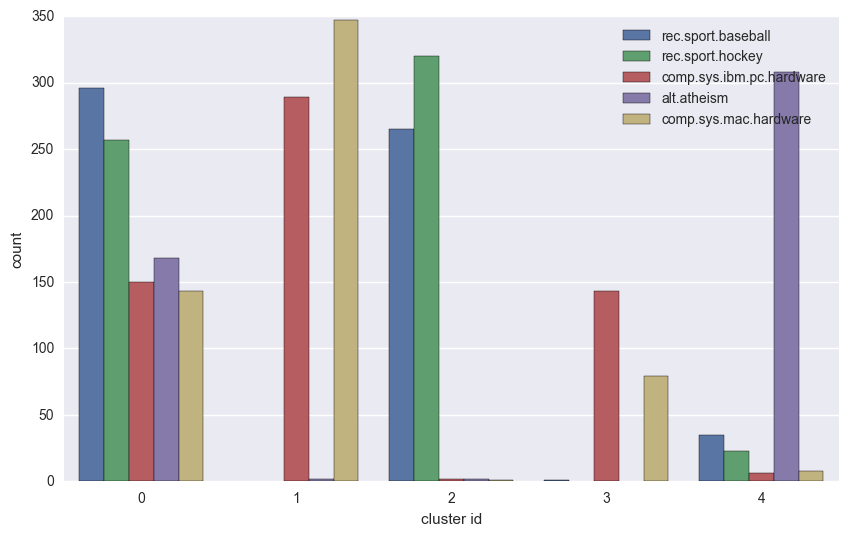

In [18]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(x=kmeans.labels_, hue=y, ax=ax)
plt.xlabel('cluster id')
plt.show()

There is only 1 cluster that contain one main type of datapoint: label 4 (alt.atheism). The other 4 clusters contain a mix. So the quality of the fit is just so so.

### ========== Question 1.7 ==========

We will now investigate using dimensionality reduction to try and improve the quality of the fit. Use the sklearn implementation of [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and its method `fit_transform()` to create a reduced reduced dataset for `n_components` = [1,2,3,5,10,20,50,100,500,1000] i.e. create datasets that are of shape `(N, d)` for `d` in `n_components`. Fit k-means to each reduced dataset and report the `inertia` and `adjusted_rand_score` for each iteration.

Plot `adjusted_rand_score` against number of principal components (label graph). Use a log scale on the x axis. Below the graph:
1. describe what it shows
1. explain why we cannot use inertia to choose the best number of principal components
1. explain why dimensionality reduction could help k-means perform better

In [21]:
n_components = [1,2,3,5,10,20,50,100,500,1000]
scores = []
for n in n_components:
    pca = PCA(n_components=n)
    X_reduced = pca.fit_transform(X)
    kmeans.fit(X_reduced)
    print("{0}-components".format(n))
    print("inertia:{0}, adjusted_rand_score:{1}".format(kmeans.inertia_, adjusted_rand_score(y, kmeans.labels_)))
    scores.append(adjusted_rand_score(y, kmeans.labels_))

1-components
inertia:2.82109066477, adjusted_rand_score:0.209466028491
2-components
inertia:10.592280453, adjusted_rand_score:0.268079336483
3-components
inertia:20.4235331658, adjusted_rand_score:0.239479218068
5-components
inertia:49.8674692394, adjusted_rand_score:0.2288985833
10-components
inertia:118.178301295, adjusted_rand_score:0.213854607491
20-components
inertia:231.905790868, adjusted_rand_score:0.209500299493
50-components
inertia:492.377897319, adjusted_rand_score:0.207798369276
100-components
inertia:820.096306441, adjusted_rand_score:0.225048950168
500-components
inertia:2145.62769513, adjusted_rand_score:0.205869464934
1000-components
inertia:2593.16646207, adjusted_rand_score:0.231640388002


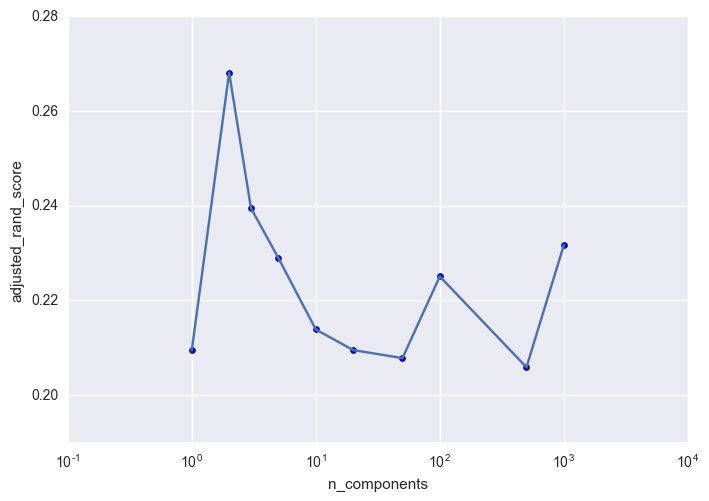

In [22]:
plt.scatter(n_components,scores)
plt.plot(n_components,scores, )
plt.xscale("log")
plt.xlabel('n_components')
plt.ylabel('adjusted_rand_score')
plt.show()

1. The figure shows that adjusted_rand_score changes with the change of the number of components. At the components of 2, we get the best performance.
2. On the one hand, inertia is the sum of distances of samples to their closest cluster center. With the increasement of cluster number, inertia is supposed to increase. On the other hand, inertia is useful only for some dataset,not all. So we cannot use inertia to choose the best n-components.
3. In terms of performance, having data of high dimensionality is problematic because (a) it can mean high computational cost to perform learning and inference and (b) it often leads to overfitting. Dimensionality reduction addresses both of these problems...  curse of dimensionality

### ========== Question 1.8 ==========

1. So we can visualise the data, create X_2d: the dataset X transformed down to 2 principal component dimensions. Use sklearn's implementation of [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and its method `fit_transform()` to do this (as above). 

1. Create a new k-means object, `kmeans_pca`, and fit the 2d data to it. Show the adjusted rand score.

1. As above, for each cluster centre label, plot the counts of the true labels. The cluster labels are a property of the k-means object, the true labels are contained in `y`. Make sure that you label the plot axes and legend clearly. Print below it the number of data points each cluster is responsible for.

1. Finally, below the plot, comment on the difference between these clusters and the clusters on the 1000 dimensional data with respect to the distribution of the labels in each. Are they better?

adjusted_rand_score:0.268079336483


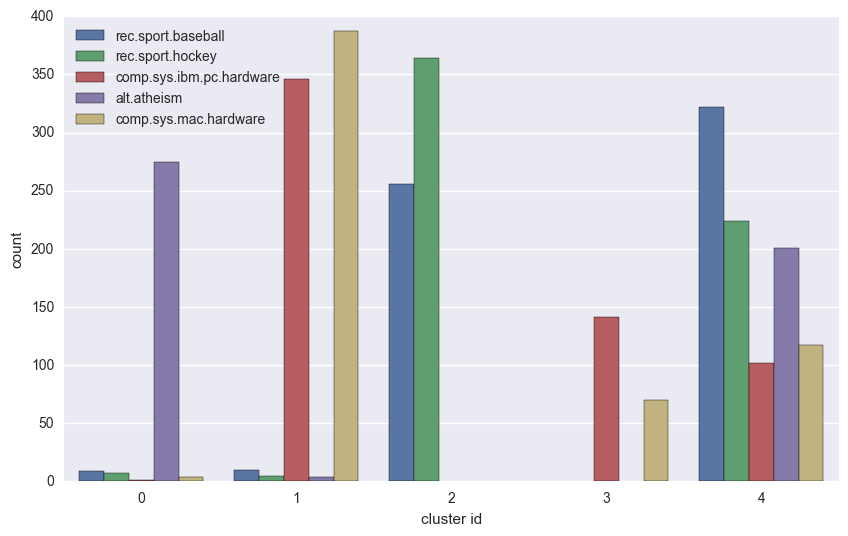

the number of datapoints with each cluster is:
[[  0 296]
 [  1 752]
 [  2 620]
 [  3 211]
 [  4 966]]


In [27]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

kmeans_pca = KMeans(n_clusters=5, random_state=1337) 
kmeans_pca.fit(X_2d)
print("adjusted_rand_score:{0}".format(adjusted_rand_score(y, kmeans_pca.labels_)))

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(x=kmeans_pca.labels_, hue=y, ax=ax)
plt.xlabel('cluster id')
plt.show()

y_pca_pred = kmeans_pca.predict(X_2d)
num_pca_cluster = itemfreq(y_pca_pred)
print("the number of datapoints with each cluster is:")
print(num_pca_cluster)


From the distribution of labels in 2d dataset is not better than the previous one because it also has only one cluster contains main labels.

### ========== Question 1.9 ==========

Given the above plot, apply a label to each cluster centre. Create a new vector, `labels_interp`, which is the same as `kmeans.labels_`, but instead of numbers, the interpreted label of the cluster centre. For example, if you decided cluster 0 was 'apples', 1 was 'pears', 2 was 'stairs', and `kmeans.labels_` was `[2, 0, 1, 1, 0]`, create  `labels_interp = ['stairs', 'apples', 'pears', 'pears', 'apples']`. Hint: an example of how to do this is given in the last line of Question 1.0.

**N.B. be careful to use the `kmeans_pca` object you created above, not the first kmeans object you made**

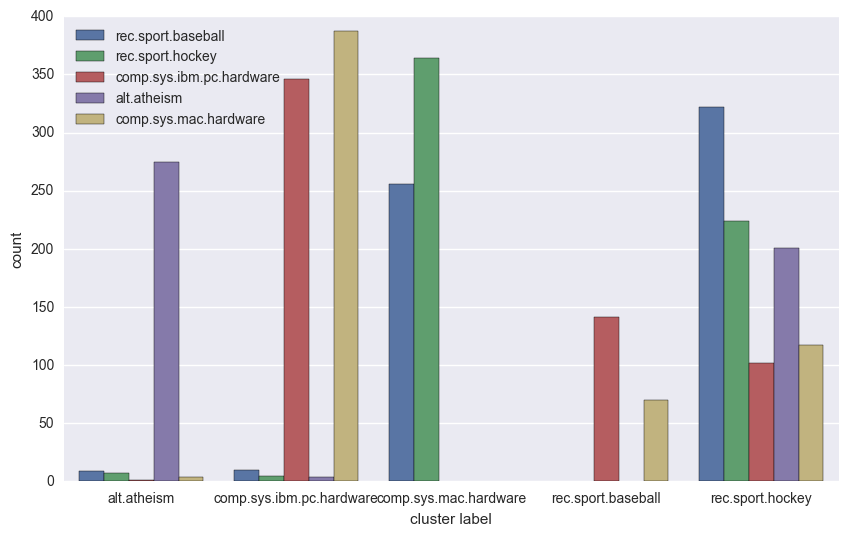

In [14]:
labels_interp = ['alt.atheism', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 
        'rec.sport.baseball', 'rec.sport.hockey']
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(x=kmeans_pca.labels_, hue=y, ax=ax)
ax.set_xticklabels(labels_interp)
plt.xlabel('cluster label')
plt.show()

### ========== Question 1.10 ==========

Produce a normalised (by true label) confusion matrix of your interpreted labels from the k-means clustering and the true labels. As usual, you may use any functions from previous assignments or labs. Clearly label the axes of the plot. Check that these confusions correlate with your expectations! N.B. this is just a slightly different way of interpreting the information in the count plot above (focussed this time on the true labels).

In [15]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

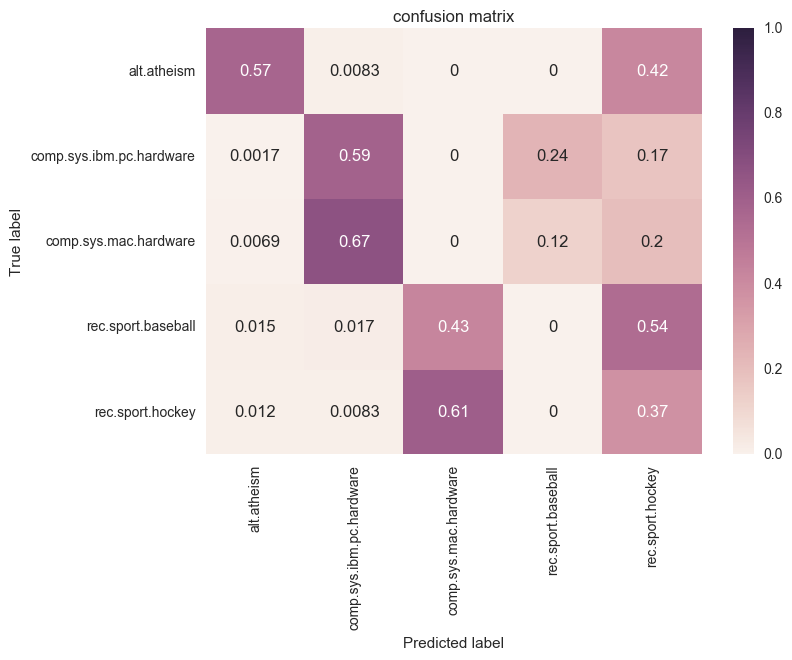

In [28]:
cm = confusion_matrix(y_num, y_pca_pred)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=cats, title='confusion matrix')


### ========== Question 1.11 ==========

Since we are now in 2 dimensions, let's visualise the data, the cluster centres, and the decision boundaries via a [Voronoi_diagram](https://en.wikipedia.org/wiki/Voronoi_diagram). You'll essentially be able to copy and paste the code from the [sklearn kmeans digits example](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) and edit a few bits to get over half marks.

Clearly mark each cluster centre.

For full marks, additionally:
* label each cluster centre with the inferred cluster label
* create a second plot which clearly shows where the true classes lie within the pca space e.g. the [sklearn PCA example here](http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html)

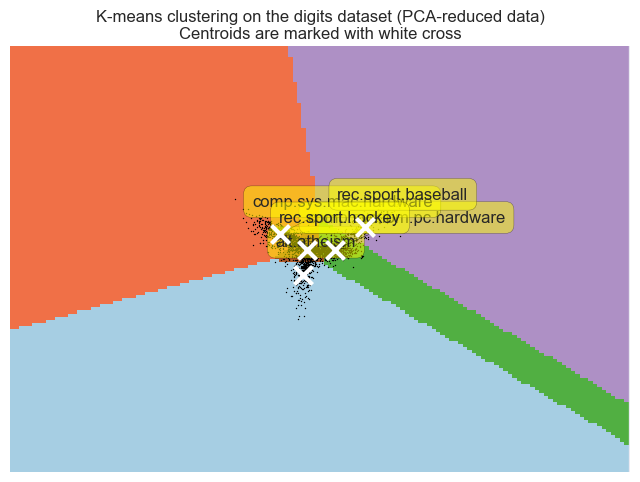

In [31]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans_pca.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(X_2d[:, 0], X_2d[:, 1], 'k.', markersize=2)

# Plot the centroids as a white X
centroids = kmeans_pca.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')

for label, x, y in zip(labels_interp, centroids[:, 0], centroids[:, 1]):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', #ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

explained variance ratio (first two components): [ 0.61244641  0.38755359]


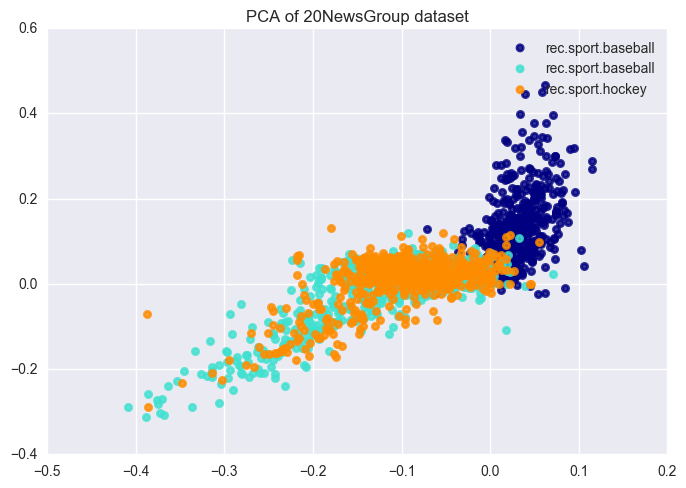

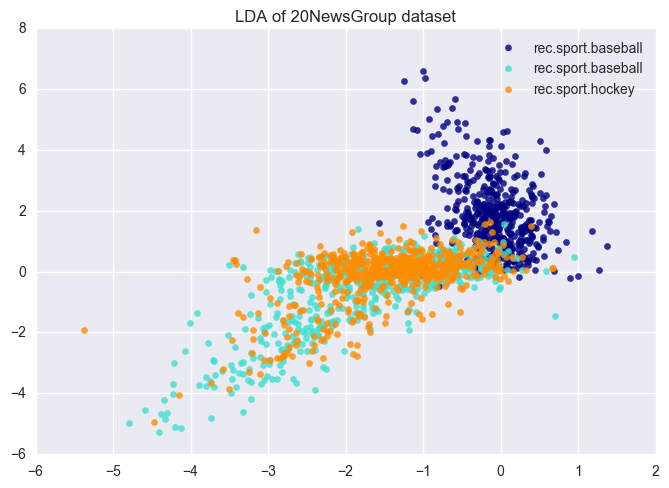

In [25]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

target_names = y
pca = PCA(n_components=2)
X_r = pca.fit(X_2d).transform(X_2d)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X_2d, y).transform(X_2d)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise', 'darkorange','blue','red']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r[y_num == i, 0], X_r[y_num == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of 20NewsGroup dataset')

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r2[y_num == i, 0], X_r2[y_num == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of 20NewsGroup dataset')


### ========== Question 1.12  ==========

*Write a **1 or 2 sentence** answer for each question*.

1. Is the kmeans algorithm deterministic?
1. Did the algorithm you ran above in Question 1.1 do multiple initialisations? If not, explain why it was not necessary. If so, how was the final model selected?
1. The default method for initialising centres in the sklearn implementation is [kmeans++](https://en.wikipedia.org/wiki/K-means%2B%2B). Name another method for initialising and a problem with it.

1. The kmeans algorithm is not deterministic because the final result is determined by random_state(the selection of initial centers).
2. Yes. Because the initial cluster centers matter the result significantly. If we choose bad cluster centers, it will cause a bad performance. So it does multiple initialisations to find the optimal centers so that every time when we run the code, we can get a similar result.
3. Grid search. The problem is it costs a lot time.

## 2. PCA with MNIST Data [50%]

In the second part of the assignment we will explore the MNIST digits dataset. We expect the digits to lie in a lower-dimensional manifold and want to examine the representation we get by applying Principal Components Analysis (PCA). PCA maps the data into a new space by effectively rotating the base vectors of the input space to the directions with the highest variance. We will assess the impact of this mapping to the classification task and the separability of the data in the PCA space.

### ========== Question 2.0 ==========

Run the cell below to load the digits object and print its description.

**Do not change any of the code in this question**

In [57]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.DESCR)

Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is a

### ========== Question 2.1 ==========

If you execute `digits.keys()`, you'll see this object contains the data, the targets (the labels), and the images (the data reshaped to 8x8 images). More typically the mnist data are [28x28 images](http://yann.lecun.com/exdb/mnist/), but this is a preprocessed version. 

1. Use the pandas describe method on the data to get a feel for the range of each dimension
1. Print the max/min values for each dimension
1. Extract the standard deviations from the output of the describe method (just another DataFrame with 'std' as one of the index values), reshape to an 8x8 image, and plot a heatmap (use `sns.heatmap()`) to show you which dimensions vary the most. For a bonus mark, produce a plot like this for each digit. *Hint: you can use `.groupby(digits.target)` before calling `.describe()`*.
1. Use `sns.heatmap()` to plot the first 9 digits in the dataset

Below the plots:
1. Are all of the dimensions going to be equally helpful for modelling? Explain.

In [58]:
#1.Use the pandas describe method on the data to get a feel for the range of each dimension
data = pd.DataFrame(data=digits['data'])
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
count,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,...,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.0,0.303840,5.204786,11.835838,11.848080,5.781859,1.362270,0.129661,0.005565,1.993879,...,3.725097,0.206455,0.000556,0.279354,5.557596,12.089037,11.809126,6.764051,2.067891,0.364496
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.196160,...,4.919406,0.984401,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,0.000000,0.000000,0.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.000000,3.000000,...,7.000000,0.000000,0.000000,0.000000,10.000000,16.000000,16.000000,12.000000,2.000000,0.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,15.000000,2.000000,16.000000,...,16.000000,13.000000,1.000000,9.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000


In [59]:
#2.Print the max/min values for each dimension
max_values = data.max()
min_values = data.min()
print("max_values for each dimension:")
print(max_values)
print("min_values for each dimension:")
print(min_values)

max_values for each dimension:
0      0.0
1      8.0
2     16.0
3     16.0
4     16.0
5     16.0
6     16.0
7     15.0
8      2.0
9     16.0
10    16.0
11    16.0
12    16.0
13    16.0
14    16.0
15    12.0
16     2.0
17    16.0
18    16.0
19    16.0
20    16.0
21    16.0
22    16.0
23     8.0
24     1.0
25    15.0
26    16.0
27    16.0
28    16.0
29    16.0
      ... 
34    16.0
35    16.0
36    16.0
37    16.0
38    14.0
39     0.0
40     4.0
41    16.0
42    16.0
43    16.0
44    16.0
45    16.0
46    16.0
47     6.0
48     8.0
49    16.0
50    16.0
51    16.0
52    16.0
53    16.0
54    16.0
55    13.0
56     1.0
57     9.0
58    16.0
59    16.0
60    16.0
61    16.0
62    16.0
63    16.0
dtype: float64
min_values for each dimension:
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
25

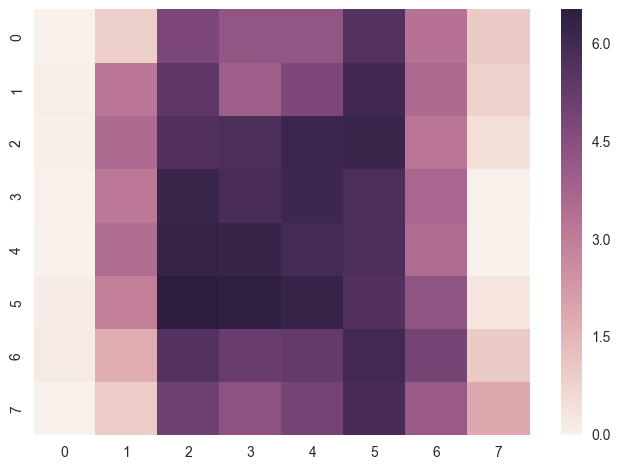

In [60]:
#3.Extract the standard deviations from the output of the describe method (just another DataFrame with 'std' as one of the index values), reshape to an 8x8 image, and plot a heatmap (use sns.heatmap()) to show you which dimensions vary the most.
std_values = data.std()
std_values = std_values.reshape(8,8)
sns.heatmap(std_values)

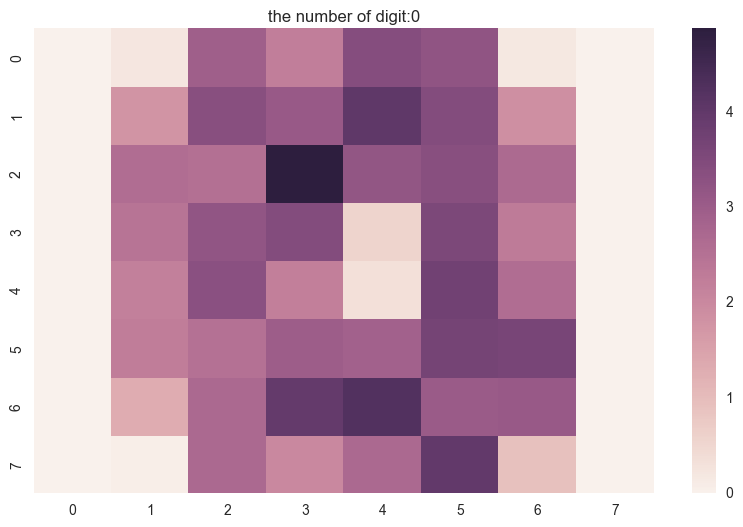

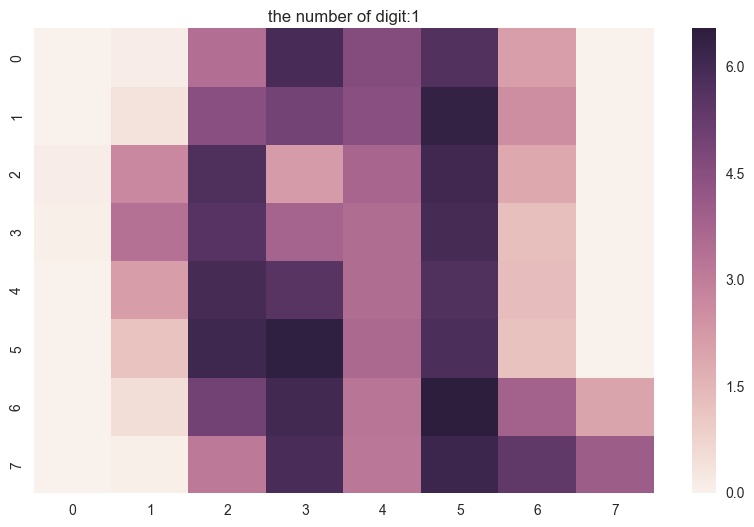

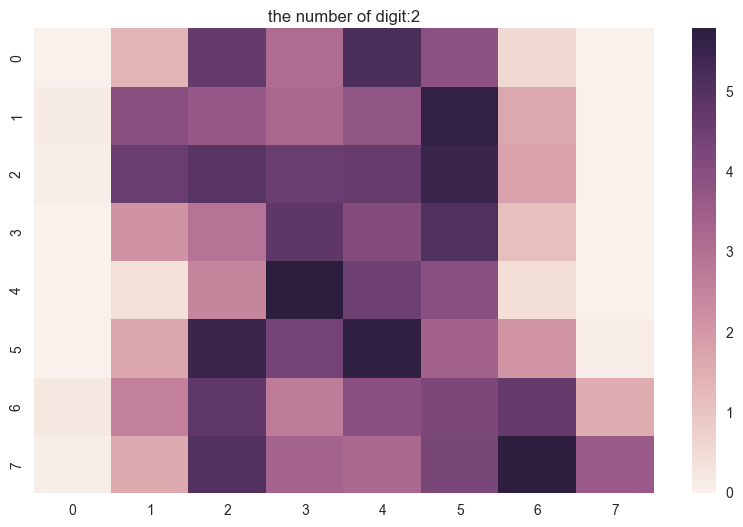

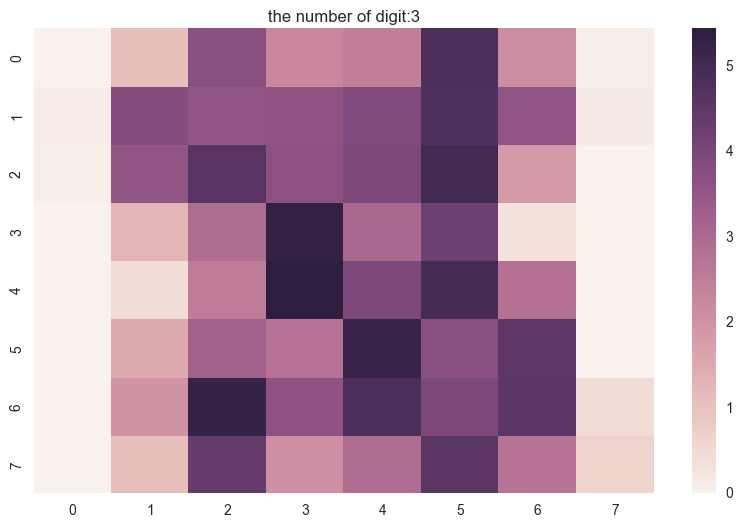

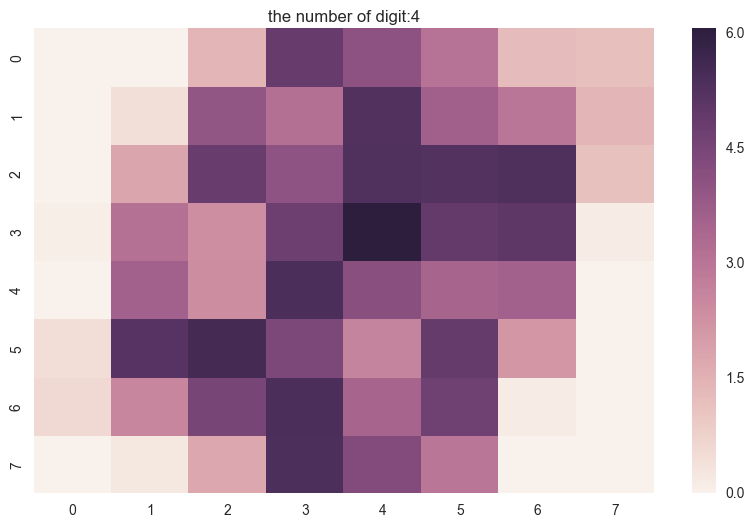

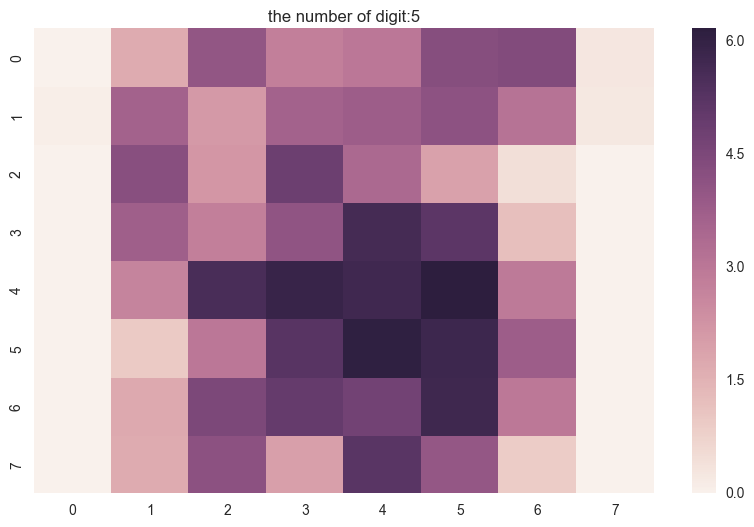

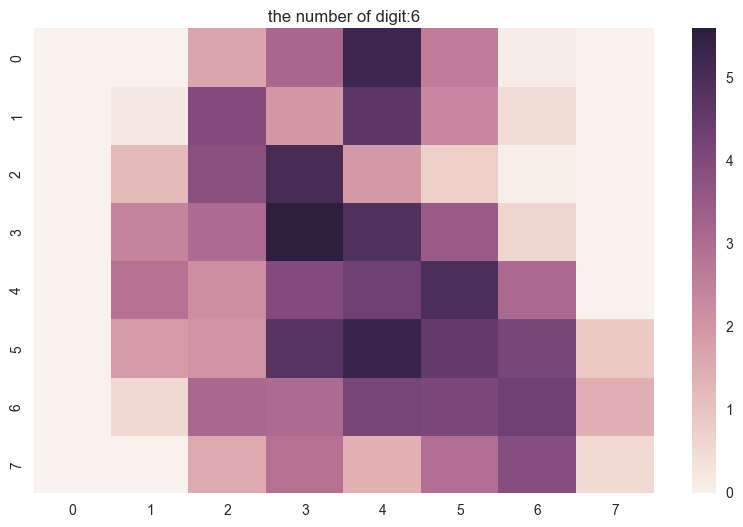

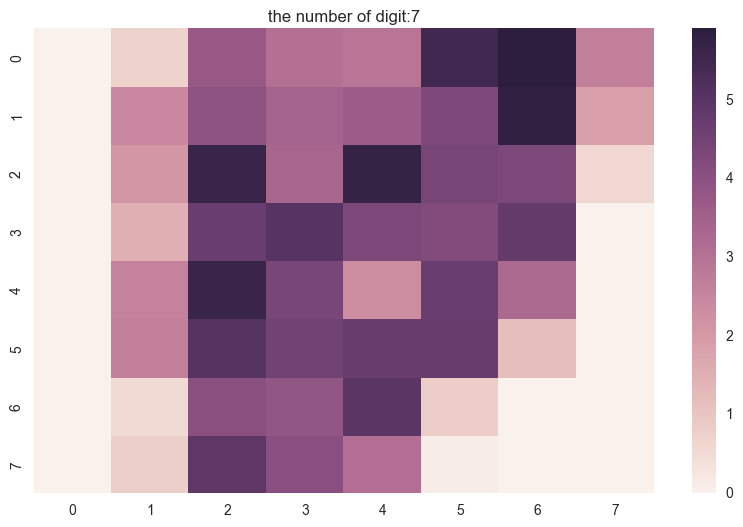

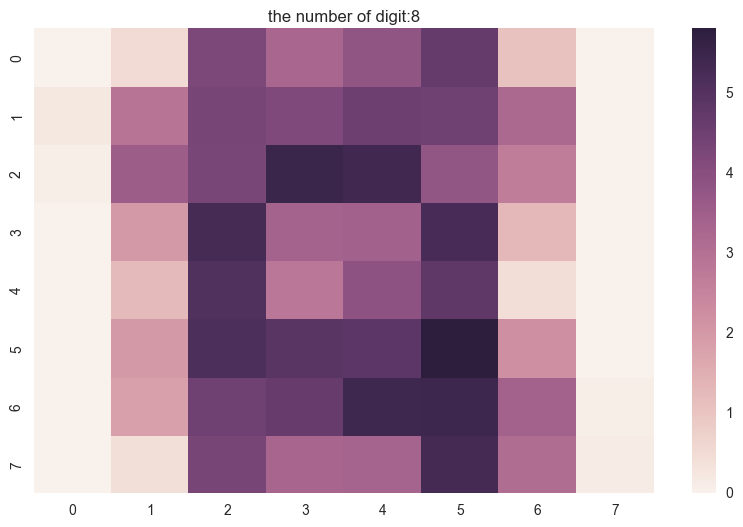

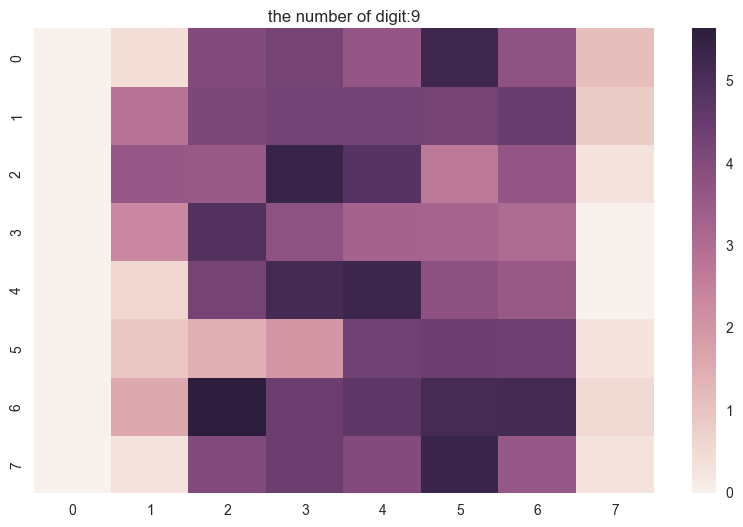

In [27]:
#3.For a bonus mark, produce a plot like this for each digit. Hint: you can use .groupby(digits.target) before calling .describe().
new_data = data.groupby(digits.target)
for num in range(10):
    fig,ax = plt.subplots(figsize=(10,6))
    temp = new_data.get_group(num)
    temp_std_values = temp.std()
    temp_std_values = temp_std_values.reshape(8,8)
    sns.heatmap(temp_std_values)
    ax.set_title('the number of digit:{0}'.format(num))


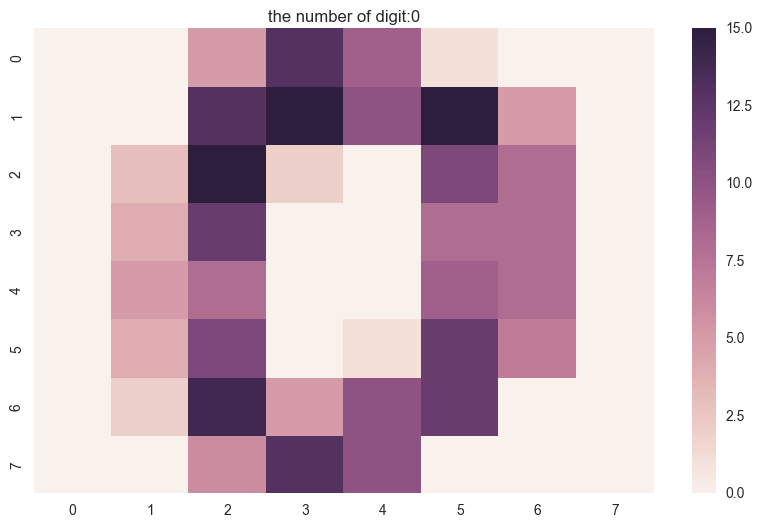

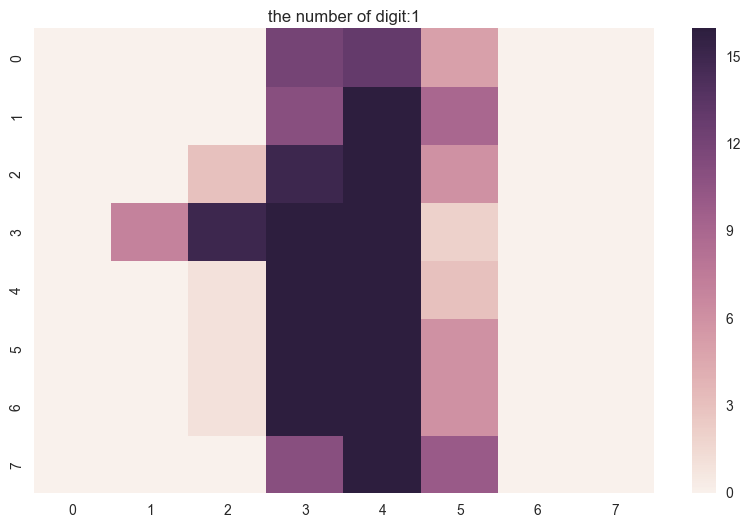

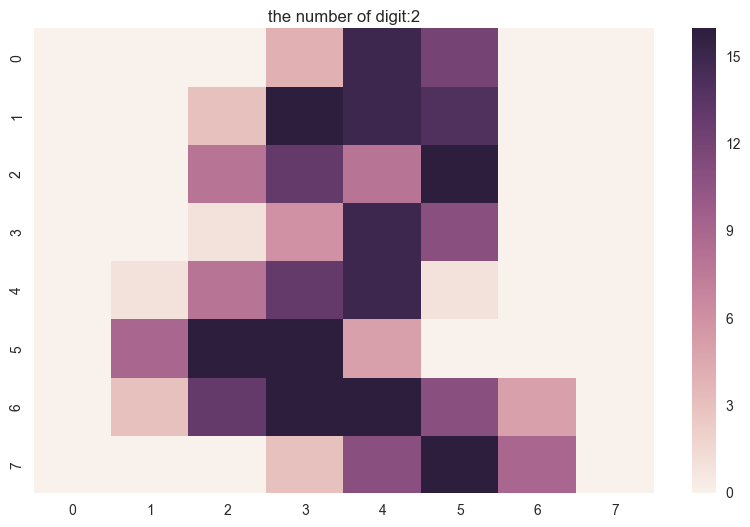

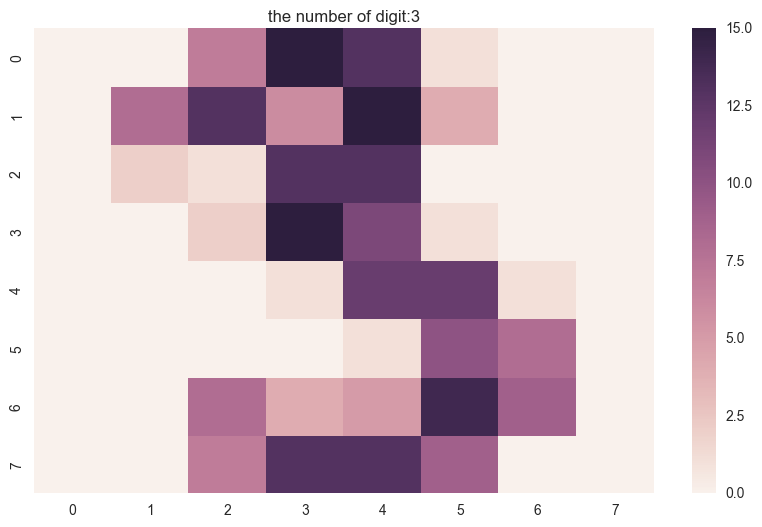

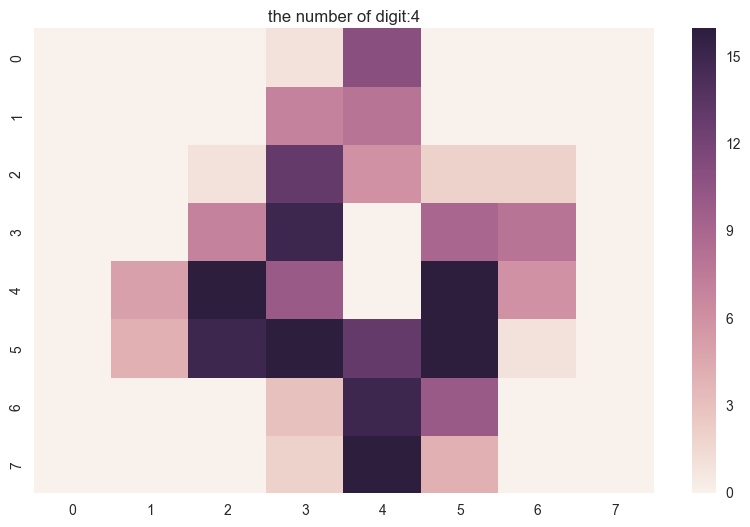

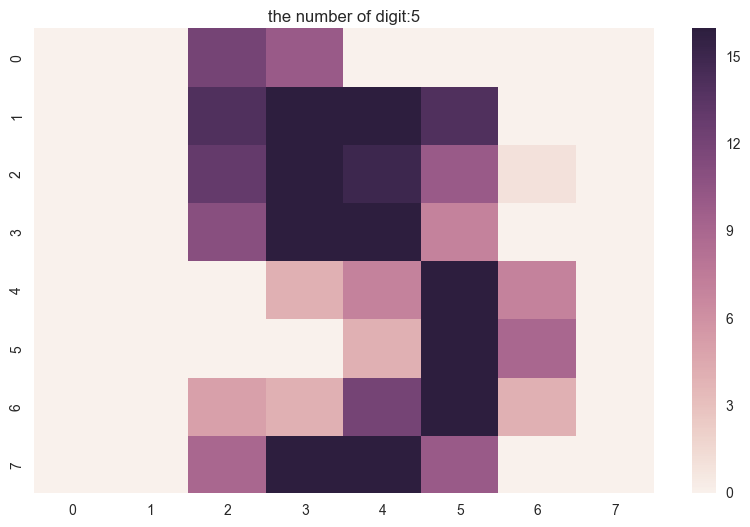

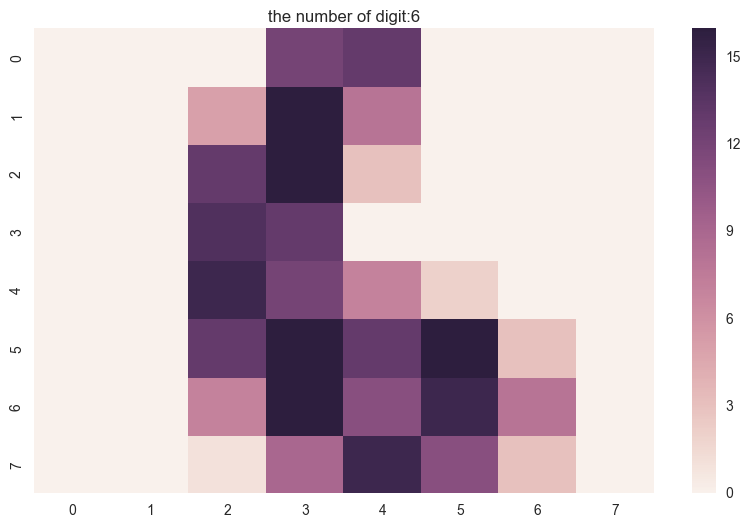

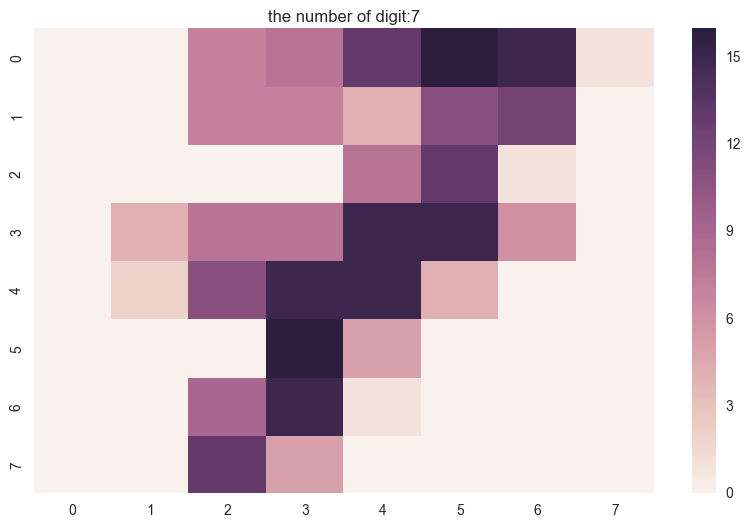

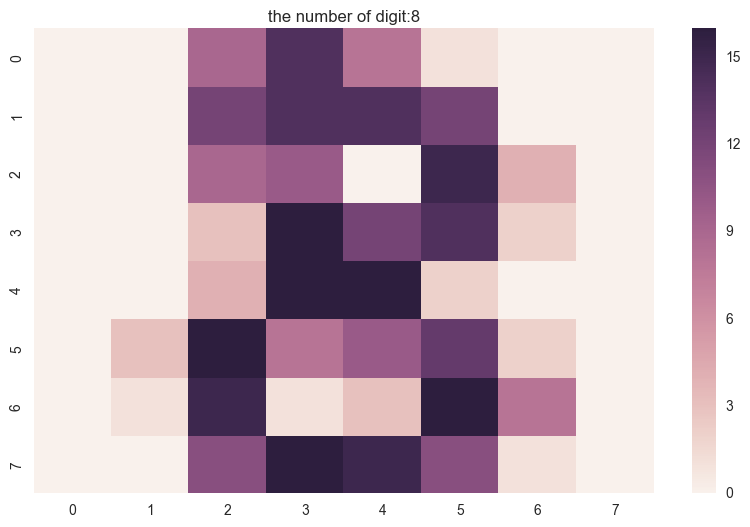

In [28]:
#4.Use sns.heatmap() to plot the first 9 digits in the dataset
for num in range(9):
    fig,ax = plt.subplots(figsize=(10,6))
    digit = digits.images[num]
    sns.heatmap(digit)
    ax.set_title('the number of digit:{0}'.format(num))

No. From the plots above, we can see that not all of the dimensions are quite useful. For instance, some digits have the same values on the same position, which means the dimension is useless. Because what we need is the dimension that contains unique features so that it can seperate the digit from others.

### ========== Question 2.2 ==========

Create a new `PCA` object with `n_components = digits.data.shape[1]`. Plot the explained variance **ratio** against the number of components. You may find [this example](http://scikit-learn.org/stable/auto_examples/plot_digits_pipe.html#sphx-glr-auto-examples-plot-digits-pipe-py) quite handy...

Find the point where 95% of the variance has been explained. Use `plt.vlines()` to add a dotted verical line to the graph at that point and use `plt.annotate()` to label the number of eigenvectors used to explain that variance.

Below the plot, explain what you observe. What does this suggest about the data?

In [61]:
n_components = digits.data.shape[1]
pca = PCA(n_components=n_components)
pca.fit(digits.data)

PCA(copy=True, n_components=64, whiten=False)

In [99]:
def find_n_components():
    ratio = pca.explained_variance_ratio_
    ratio_sum = 0
    for i in range(64):
        ratio_sum += ratio[i]
        if (ratio_sum >= 0.95):
            return i
        

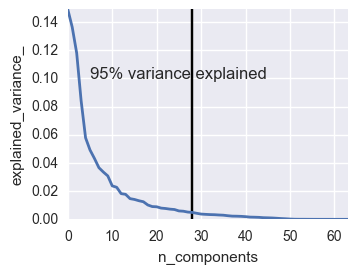

In [100]:
n_components = find_n_components()   
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
plt.vlines(n_components,ymin=0,ymax=1)
plt.annotate('95% variance explained', xy=(5, 0.05), xytext=(5, 0.1))


From the plot above, we can see only 28 components can explain 95% information. That means we can use less components and we can get a good result.

### ========== Question 2.3 ==========

You will find the eigenvectors stored within `pca.components_`. Reuse your code from Question 2.1 and plot the first 9 principal components (PCs). Below, plot `pca.mean_`. 

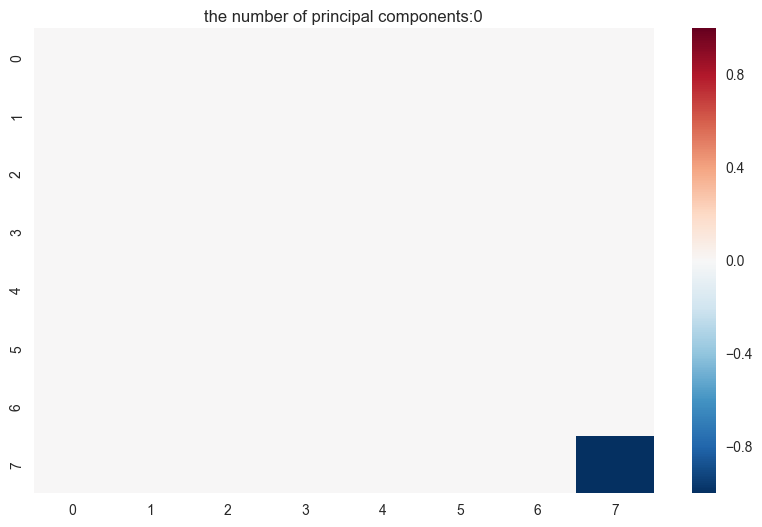

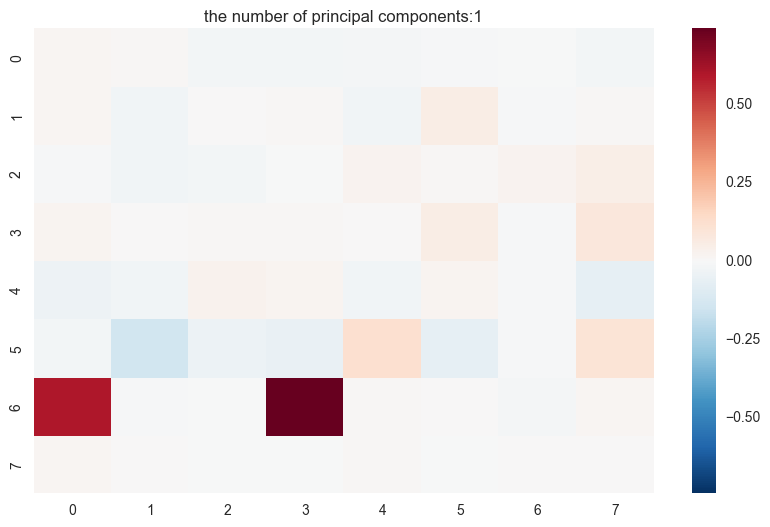

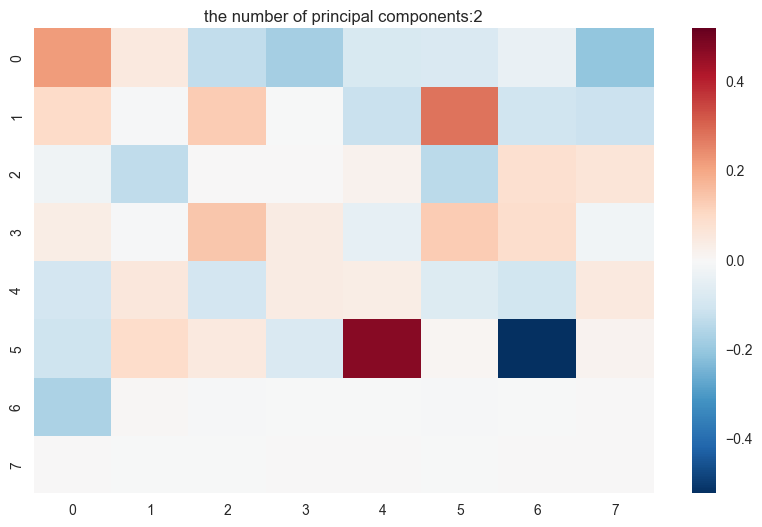

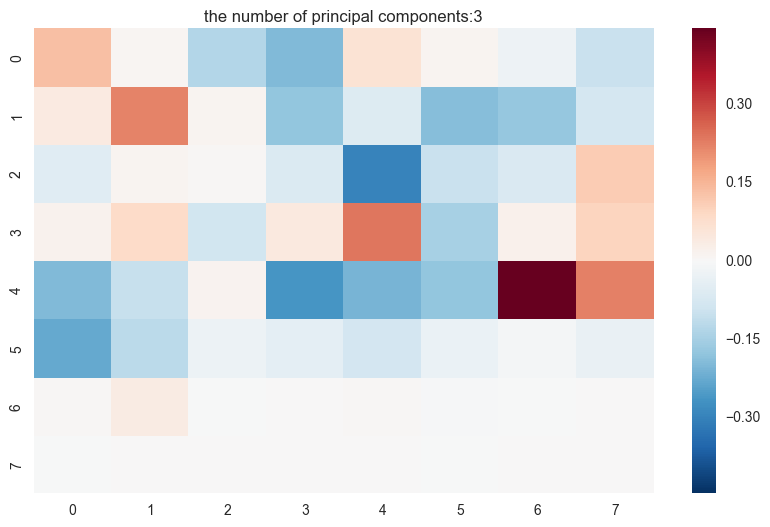

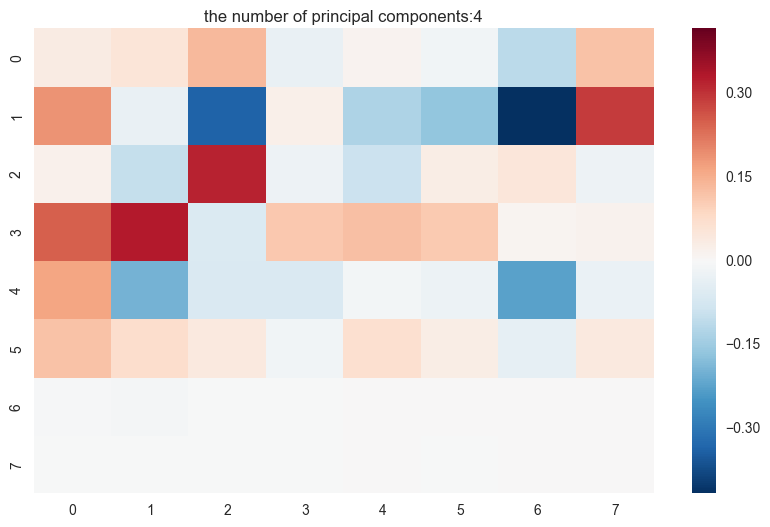

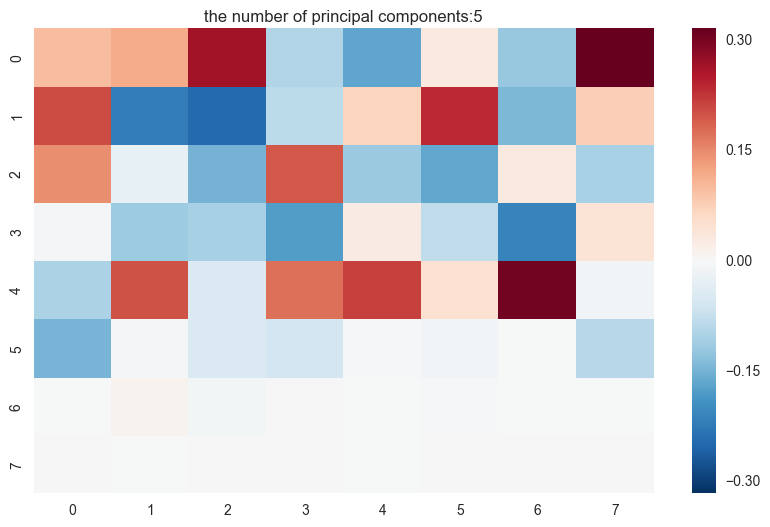

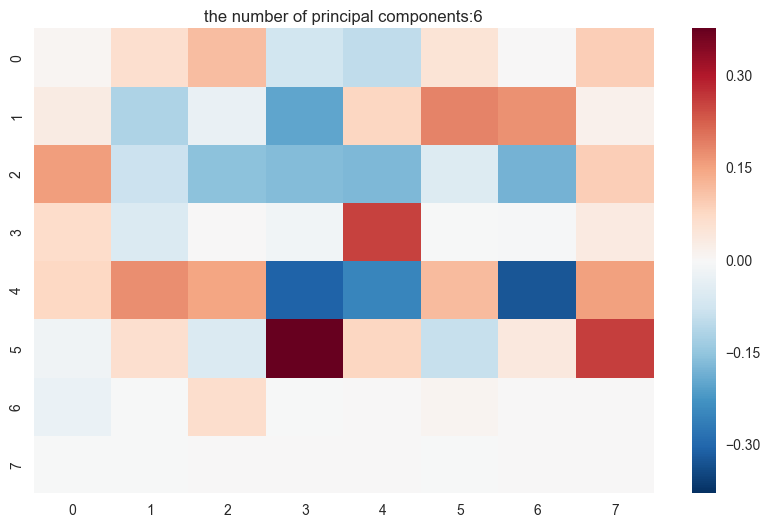

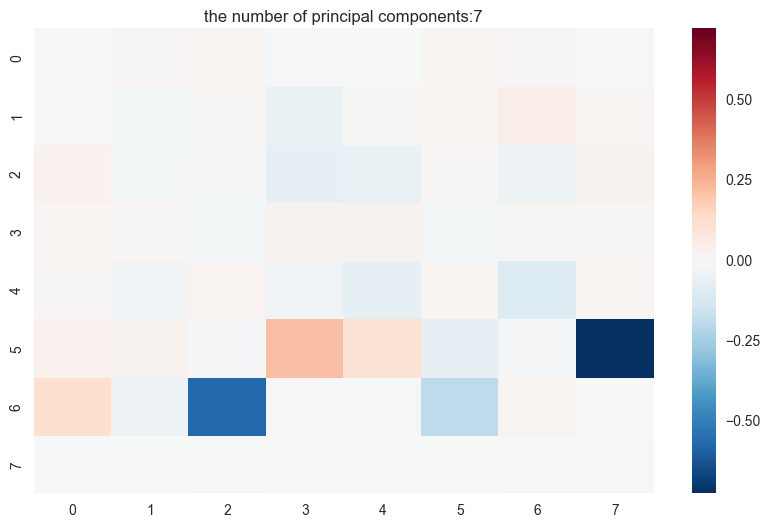

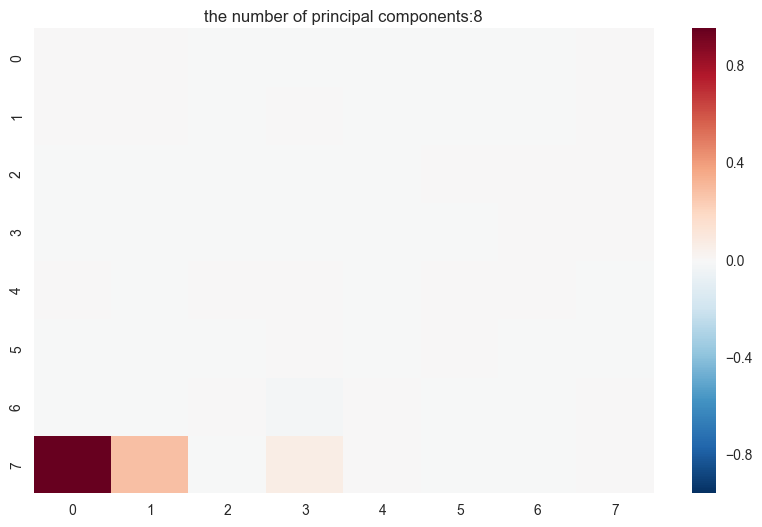

In [63]:
eigenvectors = pca.components_
for num in range(9):
    fig,ax = plt.subplots(figsize=(10,6))
    digit = eigenvectors[:,num]
    digit = digit.reshape(8,8)
    sns.heatmap(digit)
    ax.set_title('the number of principal components:{0}'.format(num))


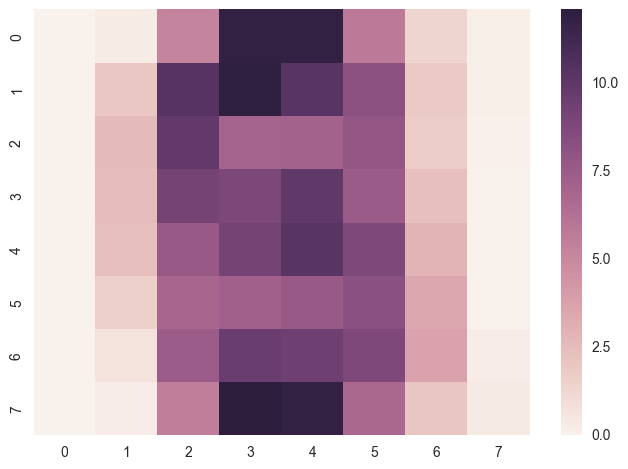

In [65]:
means = pca.mean_
means = means.reshape(8,8)
sns.heatmap(means)

### ========== Question 2.4 ==========

Now we want to make clear how these eigenvectors and the mean are used to approximate the data. `pca.transform(digits.data[idx,:].reshape(1, -1)).flatten()` will transform the digit in row `idx` into pca space. Another way to think about this is that it will give you the coefficents to multiply each eigenvector by and to add to the mean digit such that you can reconstruct the digit.

For the digit with idx = 0 (which should itself be a zero), create 4 plots:
1. The original digit
1. The digit reconstructed using 1 principal component
1. The digit reconstructed using 2 principal components
1. The digit reconstructed using 5 principal components

In the plot titles show:
1. the number of principal components used
1. the percentage of variance explained by that number of principal components
1. the coefficients of each principal component rounded to nearest integer (tip, convert to integers to reduce print space), i.e. the PCA space vector.

Below the plots, comment on the result. Do the eigenvectors produce realistic data?

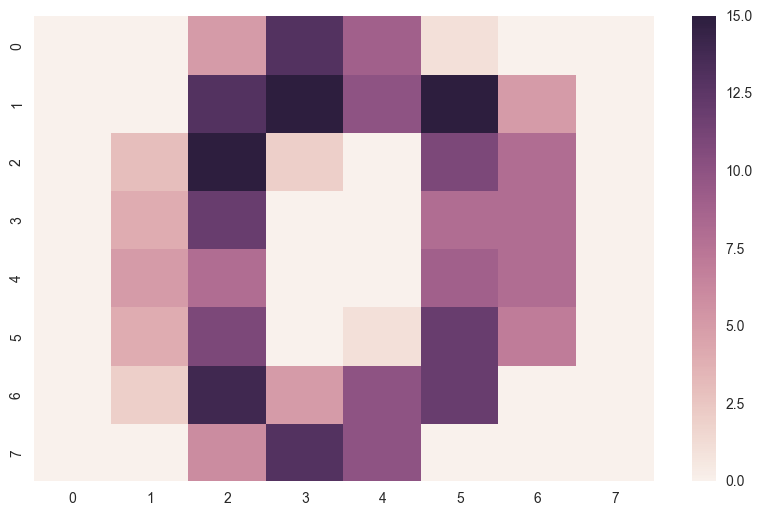

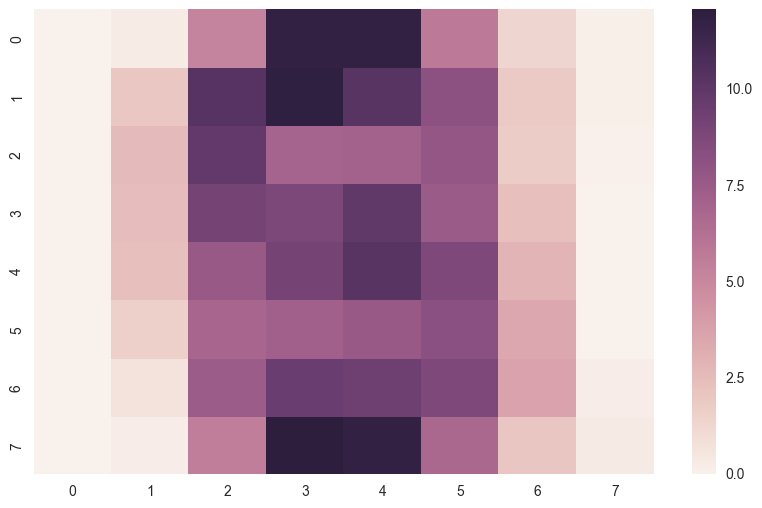

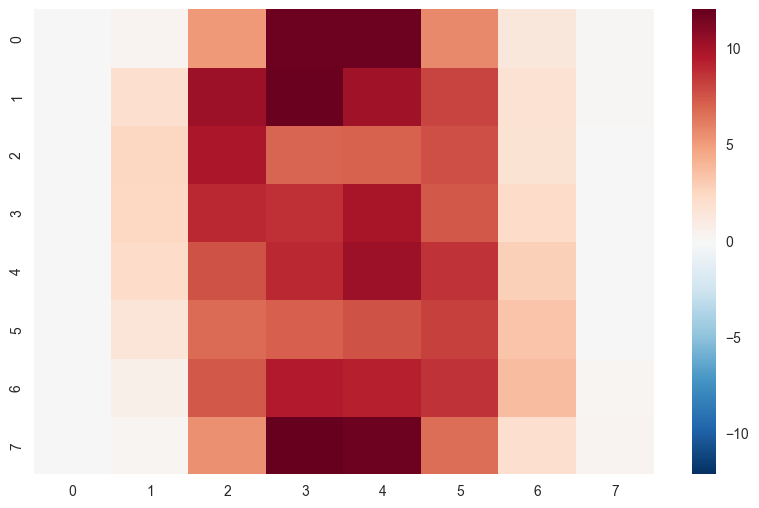

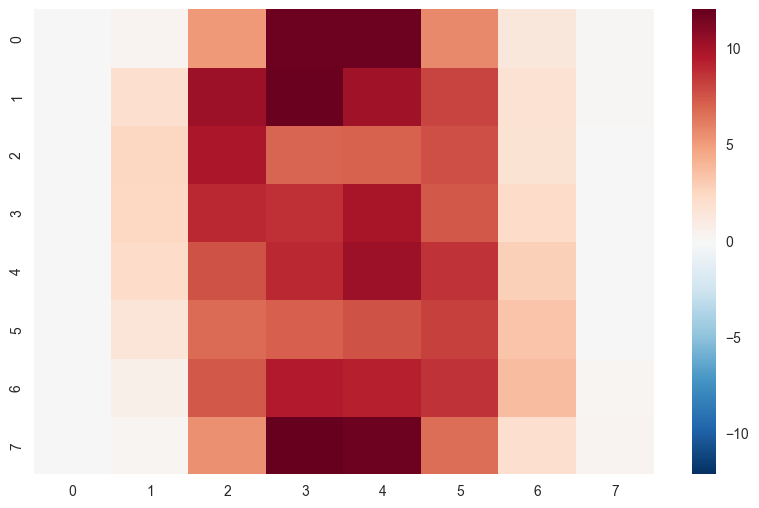

In [55]:
digit = digits["data"][0,:]
transform = pca.transform(dig.reshape(1, -1)).flatten()
pca1 = pca.components_[:,0]
pca2 = pca.components_[:,2]
pca5 = pca.components_[:,5]
mean = pca.mean_

dig_pca_1 = transform * pca1 + mean
dig_pca_2 = transform * pca1 * pca2 + mean
dig_pca_5 = transform * pca1 * pca2 * pca5 + mean
digit = digit.reshape(8,8)
dig_pca_1 = dig_pca_1.reshape(8,8)
dig_pca_2 = dig_pca_2.reshape(8,8)
dig_pca_5 = dig_pca_5.reshape(8,8)
fig,ax = plt.subplots(figsize=(10,6))
sns.heatmap(digit)
fig,ax = plt.subplots(figsize=(10,6))
sns.heatmap(dig_pca_1)
fig,ax = plt.subplots(figsize=(10,6))
sns.heatmap(dig_pca_2)
fig,ax = plt.subplots(figsize=(10,6))
sns.heatmap(dig_pca_5)


From the plots above, I think if we choose correct components, we can reconstruct the realistic data.

### ========== Question 2.5 ==========

**Challenge question** 

Fit 4 models:
1. SVC with a linear kernel, no shrinking, and a random_state on digit data
1. SVC with a linear kernel, no shrinking, and the same random_state on pca transformed digit data (use the full 64 component pca above)
1. Gaussian Naive Bayes Classifier on digit data
1. Gaussian Naive Bayes Classifier on pca transformed digit data (use the full 64 component pca above)

Use 5 fold cross validation and take the mean fold score as the result. Plot or print the results.

Below the code, explain why one classifier improved but the other did not!

In [171]:
n = digits.data.shape[0]
X = digits.data
y = digits['target']
arr = []
scores = []
kf = KFold(n, n_folds=5, shuffle=True, random_state=0)
#1
for train_indices, test_indices in kf:
    svc_linear = SVC(kernel='linear', shrinking=False, random_state=1)
    svc_linear.fit(X[train_indices], y[train_indices])
    score = svc_linear.score(X[test_indices], y[test_indices])
    arr.append(score)
arr = np.array(arr)
scores.append(np.mean(arr))

#2
arr = []
pca = PCA(n_components=64)
X_pca = pca.fit_transform(digits.data)
for train_indices, test_indices in kf:
    svc_linear = SVC(kernel='linear', shrinking=False, random_state=1)
    svc_linear.fit(X_pca[train_indices], y[train_indices])
    score = svc_linear.score(X_pca[test_indices], y[test_indices])
    arr.append(score)
arr = np.array(arr)
scores.append(np.mean(arr))

#3
arr = []
for train_indices, test_indices in kf:
    nb = GaussianNB()
    nb.fit(X[train_indices], y[train_indices])
    score = nb.score(X[test_indices], y[test_indices])
    arr.append(score)
arr = np.array(arr)
scores.append(np.mean(arr))

#4
arr = []
pca = PCA(n_components=64)
X_pca = pca.fit_transform(digits.data)
for train_indices, test_indices in kf:
    nb = GaussianNB()
    nb.fit(X_pca[train_indices], y[train_indices])
    score = nb.score(X_pca[test_indices], y[test_indices])
    arr.append(score)
arr = np.array(arr)
scores.append(np.mean(arr))

In [174]:
print("the score of SVC with a linear kernel, no shrinking, and a random_state on digit data:", scores[0])
print("the score of SVC with a linear kernel, no shrinking, and a random_state on pca transformed digit data:", scores[1])
print("the score of Gaussian Naive Bayes Classifier on digit data:", scores[2])
print("the score of Gaussian Naive Bayes Classifier on pca transformed digit data:", scores[3])

the score of SVC with a linear kernel, no shrinking, and a random_state on digit data: 0.984422779325
the score of SVC with a linear kernel, no shrinking, and a random_state on pca transformed digit data: 0.984422779325
the score of Gaussian Naive Bayes Classifier on digit data: 0.833611884865
the score of Gaussian Naive Bayes Classifier on pca transformed digit data: 0.88872175797


PCA is aimed at dimensionality reduction, which performs a linear mapping of the data to a lower-dimensional space. Because when the dimensionality increases, the volume of the space increases so fast that the available data become sparse. This sparsity is problematic for any method that requires statistical significance.So it can help improve the performance of classifiers, such as Gaussian Naive Bayes Classifier. However, for SVMs, the complexity of trained classifier is characterized by the support vectors rather than the dimensionality of the data. Thus, an SVM with a small number of support vectors can have good generalization, even when the dimensionality of the data is high.